In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.losses import BinaryCrossentropy

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

from HigherTier import HigherTierModel
from HigherTier import PerformanceFuncs

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
#trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_*.npz')
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_*_shower.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_shower.npz', '/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_1_shower.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 10
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 10))
variables_test = np.empty((0, 10))
# Training cut
trainingCutDCA_train = np.empty((0), dtype='float')
trainingCutDCA_test = np.empty((0), dtype='float')
# Truth
y_train = np.empty((0))
y_test = np.empty((0))
isTruePrimaryLink_train = np.empty((0), dtype='int')
isTruePrimaryLink_test = np.empty((0), dtype='int')

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Training cut
    trainingCutDCA_train = np.concatenate((trainingCutDCA_train, data['trainingCutDCA_train']), axis=0)
    trainingCutDCA_test = np.concatenate((trainingCutDCA_test, data['trainingCutDCA_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)
    isTruePrimaryLink_train = np.concatenate((isTruePrimaryLink_train, data['isTruePrimaryLink_train']), axis=0)
    isTruePrimaryLink_test = np.concatenate((isTruePrimaryLink_test, data['isTruePrimaryLink_test']), axis=0)                                             

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_0_shower.npz , This may take a while...
Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/files/ccnutree_1_shower.npz , This may take a while...


In [5]:
###########################################################
# I made a mistake with the opening angle so delete it for now :(
###########################################################

variables_train = np.delete(variables_train, [9], axis=1)
variables_test = np.delete(variables_test, [9], axis=1)

In [6]:
# import math

# minValue = np.min(variables_train[:, 9][variables_train[:, 9] > -1])

# for i in range(variables_train.shape[0]) : 
#     if (math.isnan(variables_train[i][9]) or math.isinf(variables_train[i][9])) :
#         variables_train[i][9] = minValue
        
# for i in range(variables_test.shape[0]) : 
#     if (math.isnan(variables_test[i][9]) or math.isinf(variables_test[i][9])) :
#         variables_test[i][9] = minValue

In [7]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (412988, 9)
variables_test.shape: (45888, 9)
y_train.shape: (412988,)
y_test.shape: (45888,)
trainingCutDCA_train.shape: (412988,)
trainingCutDCA_test.shape: (45888,)
isTruePrimaryLink_train.shape: (412988,)
isTruePrimaryLink_test.shape: (45888,)


In [8]:
###########################################################
# Apply training cut topology mask
###########################################################

# These are inspired by hand-scanning :'(
MAX_TRAINING_CUT_DCA = 50.0

######################
# training set first
######################
# Make mask
passTrainingCutDCA_train = trainingCutDCA_train < MAX_TRAINING_CUT_DCA
passTrainingCuts_train = passTrainingCutDCA_train

# Mask the 1D variables... shape=(nEntries, )
y_train = y_train[passTrainingCuts_train]
trainingCutDCA_train = trainingCutDCA_train[passTrainingCuts_train]
isTruePrimaryLink_train = isTruePrimaryLink_train[passTrainingCuts_train]

# Mask the variable... shape=(nEntries, nVariables)
variables_train = variables_train[[[entry] * nVariables for entry in passTrainingCuts_train]].reshape(-1, nVariables)

######################
# now test set
######################
# Make mask
passTrainingCutDCA_test = trainingCutDCA_test < MAX_TRAINING_CUT_DCA
passTrainingCuts_test = passTrainingCutDCA_test

# Mask the 1D variables... shape=(nEntries, )
y_test = y_test[passTrainingCuts_test]
trainingCutDCA_test = trainingCutDCA_test[passTrainingCuts_test]
isTruePrimaryLink_test = isTruePrimaryLink_test[passTrainingCuts_test]

# Mask the variable... shape=(nEntries, nVariables)
variables_test = variables_test[[[entry] * nVariables for entry in passTrainingCuts_test]].reshape(-1, nVariables)

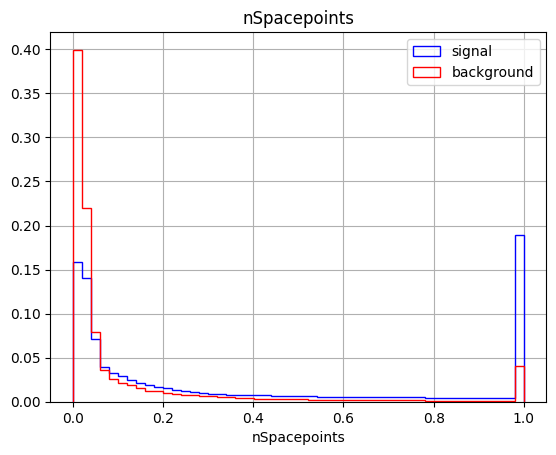

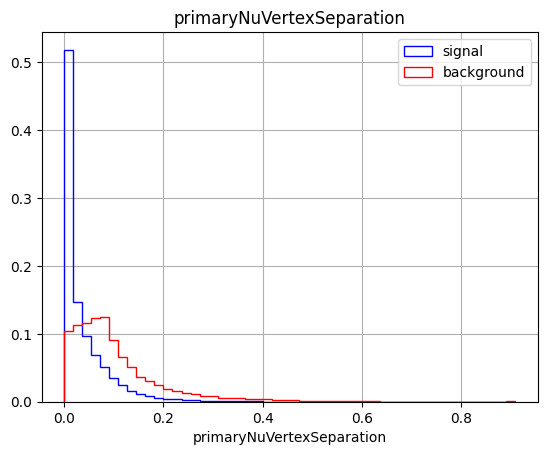

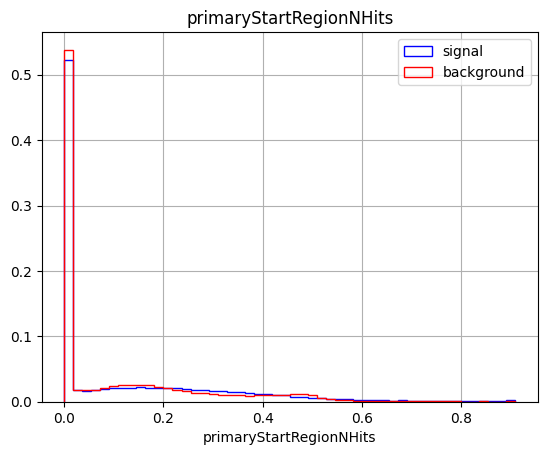

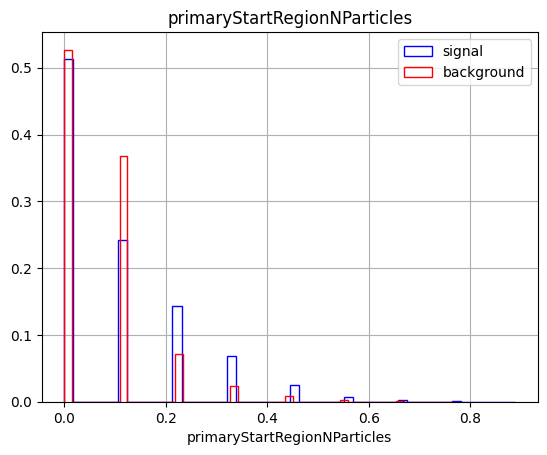

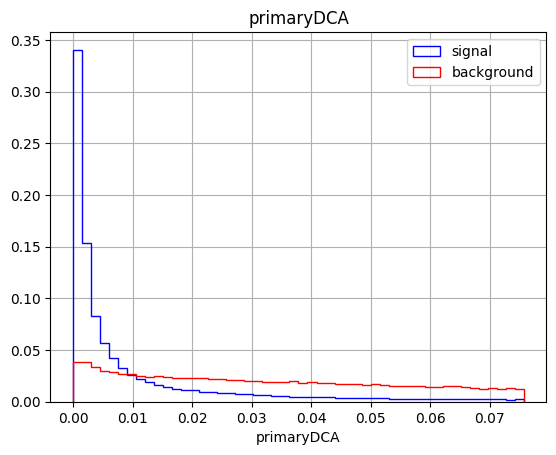

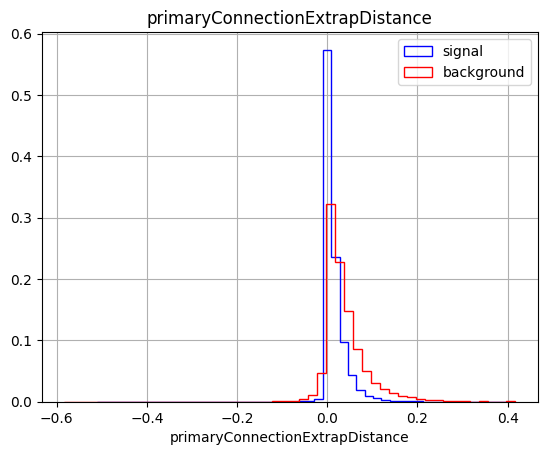

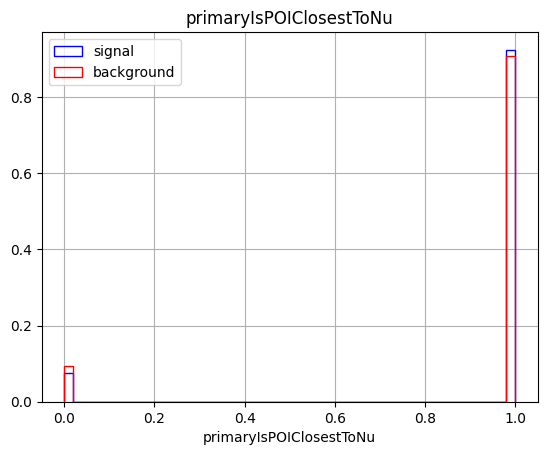

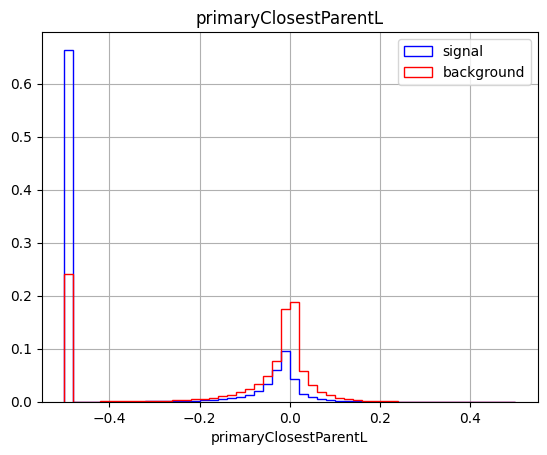

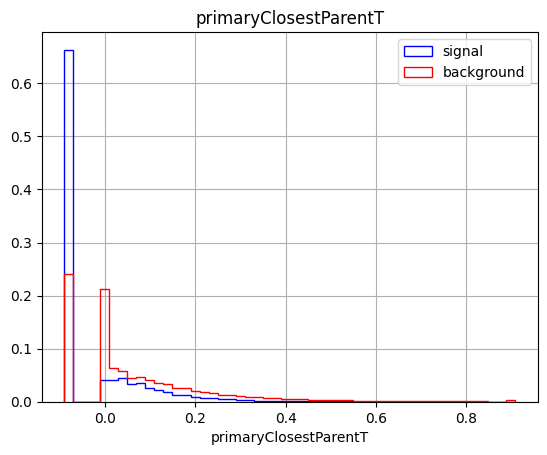

In [10]:
def drawSignalBackground(variable, truth_labels, graph_label) :
    
    signal_mask_vis = (truth_labels == 1).reshape(-1)
    background_mask_vis = (truth_labels == 0).reshape(-1)

    variable_signal = variable[signal_mask_vis].reshape(-1)
    variable_background = variable[background_mask_vis].reshape(-1)

    signal_weights = 1.0 / float(variable_signal.shape[0])
    signal_weights = np.ones(variable_signal.shape[0]) * signal_weights
    
    background_weights = 1.0 / float(variable_background.shape[0])
    background_weights = np.ones(variable_background.shape[0]) * background_weights   
        
    plt.hist(variable_signal, bins=50, color='blue', weights=signal_weights, label='signal', fill=False, histtype='step')
    plt.hist(variable_background, bins=50, color='red', weights=background_weights, label='background', fill=False, histtype='step')
    plt.title(graph_label)
    plt.xlabel(graph_label)
    plt.legend()
    plt.grid(True)
    plt.show()   
    
drawSignalBackground(variables_train[:, 0], isTruePrimaryLink_train, "nSpacepoints")
drawSignalBackground(variables_train[:, 1], isTruePrimaryLink_train, 'primaryNuVertexSeparation')
drawSignalBackground(variables_train[:, 2], isTruePrimaryLink_train, 'primaryStartRegionNHits')
drawSignalBackground(variables_train[:, 3], isTruePrimaryLink_train, 'primaryStartRegionNParticles')    
drawSignalBackground(variables_train[:, 4], isTruePrimaryLink_train, 'primaryDCA')    
drawSignalBackground(variables_train[:, 5], isTruePrimaryLink_train, 'primaryConnectionExtrapDistance')
drawSignalBackground(variables_train[:, 6], isTruePrimaryLink_train, 'primaryIsPOIClosestToNu')
drawSignalBackground(variables_train[:, 7], isTruePrimaryLink_train, 'primaryClosestParentL') 
drawSignalBackground(variables_train[:, 8], isTruePrimaryLink_train, 'primaryClosestParentT') 
# drawSignalBackground(variables_train[:, 9], isTruePrimaryLink_train, 'primaryOpeningAngle') 

In [11]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

print('')
print('ntrain:', ntrain)
print('ntest:', ntest)

variables_train.shape: (313494, 9)
variables_test.shape: (34825, 9)
y_train.shape: (313494,)
y_test.shape: (34825,)
trainingCutDCA_train.shape: (313494,)
trainingCutDCA_test.shape: (34825,)
isTruePrimaryLink_train.shape: (313494,)
isTruePrimaryLink_test.shape: (34825,)

ntrain: 313494
ntest: 34825


In [12]:
###########################################################
# Define model and optimiser and compile the model
###########################################################

model = HigherTierModel.PrimaryShowerFinalOutputModel(nVariables)
optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
model.compile(optimizer=optimiser, metrics=['accuracy'], loss=['binary_crossentropy'])

In [13]:
###########################################################
# Define class weights
###########################################################

nTrue_final = np.count_nonzero(isTruePrimaryLink_train == 1)
nBackground_final = np.count_nonzero(isTruePrimaryLink_train == 0)

maxLinks = max(nTrue_final, nBackground_final)

classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

print('nTrue_final:', nTrue_final)
print('nBackground_final:', nBackground_final)
print('classWeights_final:', classWeights_final)

nTrue_final: 236683
nBackground_final: 76811
classWeights_final: {0: 3.0813685539831535, 1: 1.0}


In [14]:
###########################################################
# Fit the model
###########################################################

filePath_final = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower'
    
# checkpoint
checkpoint_final = ModelCheckpoint(filePath_final, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Reduce the learning rate by a factor of ten when required
reduce_lr_final = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

callbacks_list_final = [checkpoint_final, reduce_lr_final]

history_final = model.fit(variables_train, isTruePrimaryLink_train, validation_data=(variables_test, isTruePrimaryLink_test), 
                          batch_size=batchSize, shuffle=True, epochs=nEpochs, callbacks=callbacks_list_final, class_weight=classWeights_final)

Epoch 1/10
4788/4899 [============================>.] - ETA: 0s - loss: 0.8610 - accuracy: 0.7156
Epoch 1: val_accuracy improved from -inf to 0.71414, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


4899/4899 [==============================] - 3s 501us/step - loss: 0.8603 - accuracy: 0.7153 - val_loss: 0.5384 - val_accuracy: 0.7141 - lr: 0.0010
Epoch 2/10
4783/4899 [============================>.] - ETA: 0s - loss: 0.8010 - accuracy: 0.7137
Epoch 2: val_accuracy improved from 0.71414 to 0.71782, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


4899/4899 [==============================] - 2s 488us/step - loss: 0.8006 - accuracy: 0.7137 - val_loss: 0.5190 - val_accuracy: 0.7178 - lr: 0.0010
Epoch 3/10
4895/4899 [============================>.] - ETA: 0s - loss: 0.7803 - accuracy: 0.7196
Epoch 3: val_accuracy improved from 0.71782 to 0.72279, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


4899/4899 [==============================] - 2s 489us/step - loss: 0.7803 - accuracy: 0.7196 - val_loss: 0.5135 - val_accuracy: 0.7228 - lr: 0.0010
Epoch 4/10
4854/4899 [============================>.] - ETA: 0s - loss: 0.7681 - accuracy: 0.7297
Epoch 4: val_accuracy improved from 0.72279 to 0.73424, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


4899/4899 [==============================] - 2s 493us/step - loss: 0.7681 - accuracy: 0.7296 - val_loss: 0.5072 - val_accuracy: 0.7342 - lr: 0.0010
Epoch 5/10
4842/4899 [============================>.] - ETA: 0s - loss: 0.7605 - accuracy: 0.7426
Epoch 5: val_accuracy improved from 0.73424 to 0.75285, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


4899/4899 [==============================] - 2s 506us/step - loss: 0.7604 - accuracy: 0.7427 - val_loss: 0.4983 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 6/10
4865/4899 [============================>.] - ETA: 0s - loss: 0.7554 - accuracy: 0.7536
Epoch 6: val_accuracy improved from 0.75285 to 0.75928, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


4899/4899 [==============================] - 3s 515us/step - loss: 0.7555 - accuracy: 0.7535 - val_loss: 0.4984 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 7/10
4826/4899 [============================>.] - ETA: 0s - loss: 0.7520 - accuracy: 0.7610
Epoch 7: val_accuracy improved from 0.75928 to 0.76146, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4899/4899 [==============================] - 3s 519us/step - loss: 0.7522 - accuracy: 0.7611 - val_loss: 0.5000 - val_accuracy: 0.7615 - lr: 0.0010
Epoch 8/10
4824/4899 [============================>.] - ETA: 0s - loss: 0.7510 - accuracy: 0.7635
Epoch 8: val_accuracy improved from 0.76146 to 0.76408, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


4899/4899 [==============================] - 3s 542us/step - loss: 0.7508 - accuracy: 0.7636 - val_loss: 0.4977 - val_accuracy: 0.7641 - lr: 1.0000e-04
Epoch 9/10
4836/4899 [============================>.] - ETA: 0s - loss: 0.7503 - accuracy: 0.7646
Epoch 9: val_accuracy improved from 0.76408 to 0.76560, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


4899/4899 [==============================] - 3s 570us/step - loss: 0.7506 - accuracy: 0.7644 - val_loss: 0.4962 - val_accuracy: 0.7656 - lr: 1.0000e-04
Epoch 10/10
4892/4899 [============================>.] - ETA: 0s - loss: 0.7503 - accuracy: 0.7651
Epoch 10: val_accuracy improved from 0.76560 to 0.76715, saving model to /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower
INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


INFO:tensorflow:Assets written to: /Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower/assets


4899/4899 [==============================] - 3s 559us/step - loss: 0.7504 - accuracy: 0.7651 - val_loss: 0.4953 - val_accuracy: 0.7672 - lr: 1.0000e-04


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


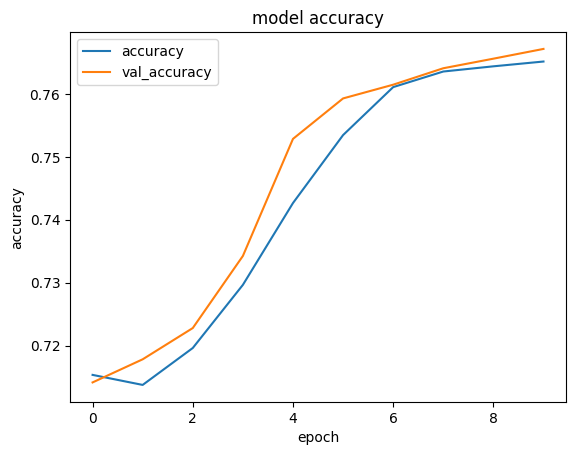

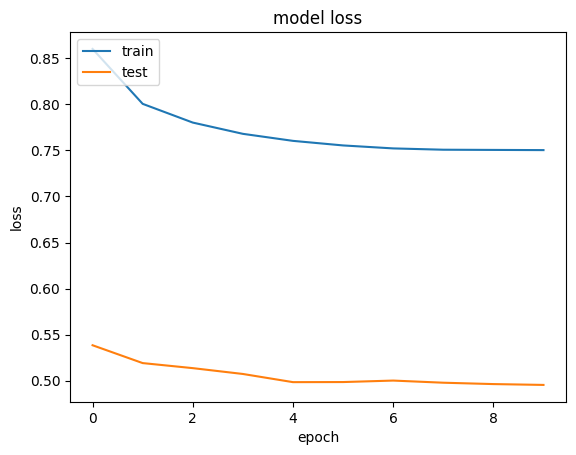

In [15]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history_final.history.keys())

# summarize history for accuracy
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

# summarize history for loss
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
###########################################################
# Evaluate the test sample
###########################################################
y_pred_final_train = model.predict(variables_train)
y_pred_final_test = model.predict(variables_test)

1089/1089 [==============================] - 1s 641us/step


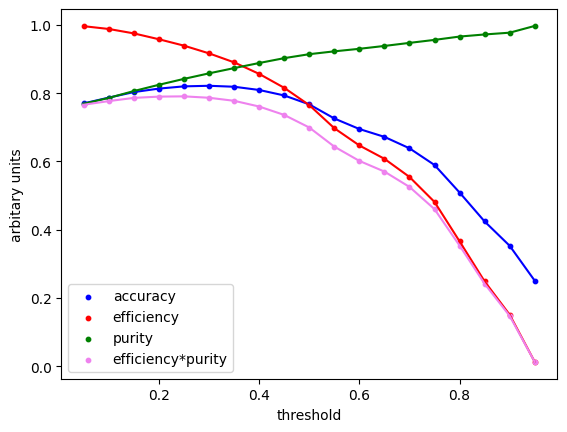

optimal_threshold_metric: 0.25


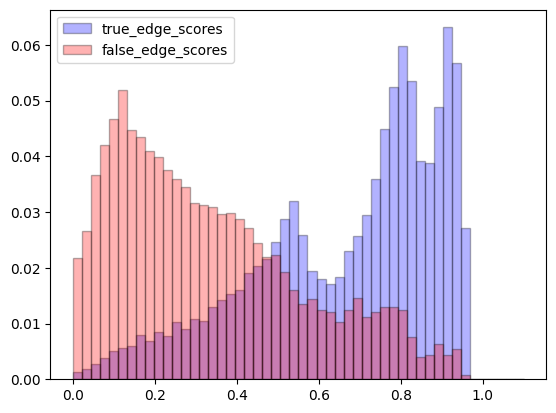

[[ 6495  1897]
 [ 6212 20221]]
[[ 3730  4662]
 [ 1608 24825]]


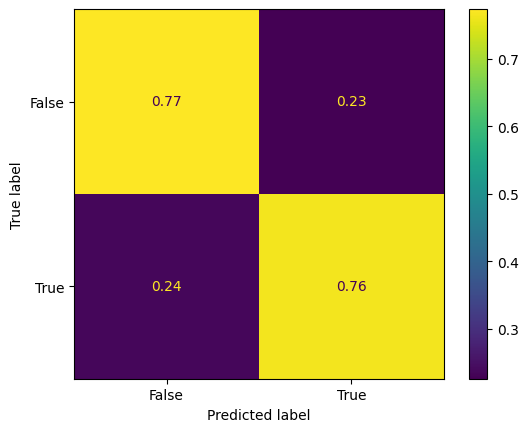

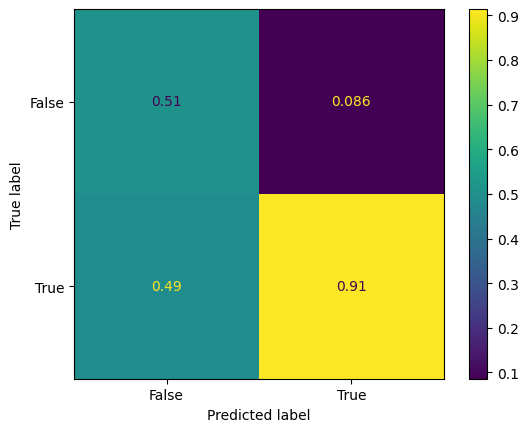

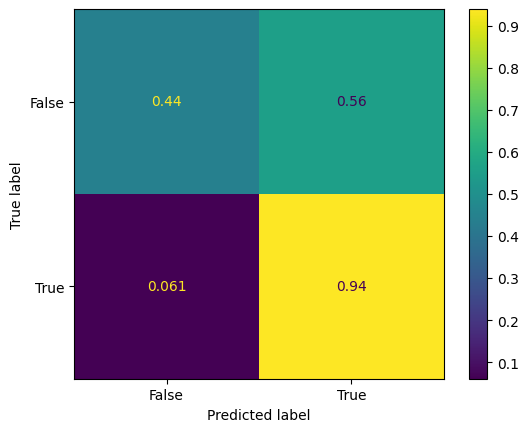

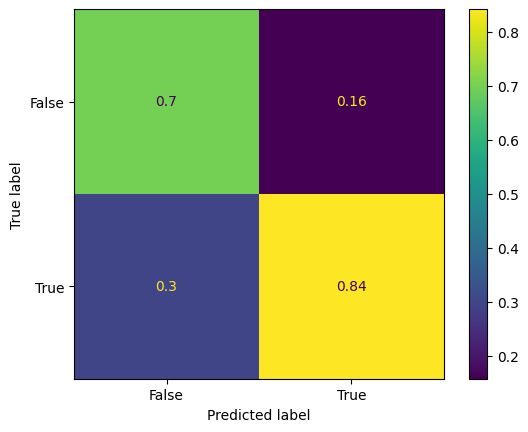

In [17]:
#######################################
# Plot final link prediction
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = PerformanceFuncs.calculate_accuracy(y_pred_final_test, isTruePrimaryLink_test)

print('optimal_threshold_metric:', optimal_threshold_metric)

PerformanceFuncs.plot_scores(y_pred_final_test, isTruePrimaryLink_test)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, 0.5)
PerformanceFuncs.draw_confusion_with_threshold(y_pred_final_test, isTruePrimaryLink_test, optimal_threshold_metric)
